In [1]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time
from datetime import datetime
import pandas as pd
import os

#create output directory for results
os.makedirs("dance_analysis_results", exist_ok=True)

In [2]:
#initialize MediaPipe components
mp_holistic = mp.solutions.holistic #full-body pose estimation
mp_drawing = mp.solutions.drawing_utils #landmarks
mp_drawing_styles = mp.solutions.drawing_styles #coloring body parts

#configure holistic model with higher accuracy
holistic = mp_holistic.Holistic(
    min_detection_confidence=0.5, #50% confidence detection
    min_tracking_confidence=0.5,
    model_complexity=2  #resource-intensiveness 
)

## **Body Parts Mapping and Analysis Categories**

The methodology represents analyzing body parts with landmarks (body points) and quantifying deviation from the original video.

In [3]:
#define body parts for tracking
body_parts = [
        "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
        "left_wrist", "right_wrist", "left_hip", "right_hip",
        "left_knee", "right_knee", "left_ankle", "right_ankle"
]

#define performance categories based on deviation from original (quantification)
match_categories = {
        0.0: "Perfect",
        0.1: "Excellent",
        0.2: "Good",
        0.3: "Fair",
        0.4: "Needs Improvement",
        0.5: "Try Again"
    }

## **Single Frame Processing Function**

Video analysis is splitted to frame-by-frame analysis. Single frame is processed and landmarks are extracted. 

In [4]:
def process_frame(frame, holistic_model):
    """
    Process a video frame to extract pose landmarks.
    
    Args:
        frame: Input video frame
        holistic: MediaPipe holistic model
    
    Returns:
        tuple: (landmarks_dict, processed_frame)
    """
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) #RGB
    
    results = holistic_model.process(rgb_frame) #MediaPipe

    processed_frame = frame.copy() #a copy for visualization
    
    #extract all landmarks
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(
            processed_frame,
            results.pose_landmarks,
            mp.solutions.holistic.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style()
        )
        
        landmarks_dict = {} #Store to the dictionary
        for idx, landmark in enumerate(results.pose_landmarks.landmark):
            landmarks_dict[f"landmark_{idx}"] = {
                "x": landmark.x,
                "y": landmark.y,
                "z": landmark.z,
                "visibility": landmark.visibility
            }
        return landmarks_dict, processed_frame
    return None, processed_frame #if landmarks are not available

## **Deviation Calculation Function**

Calculate deviation from the original on the basis of the current and reference landmarks. We apply penalty for the lack of body part visibility. Please note that we aware that this approach is not ideal as disabled or injured person are discriminated. We propose another approach in the extensions part.

In [6]:
def calculate_deviation(user_landmarks, reference_landmarks, body_parts):
    """
    Calculate the deviation between user and reference poses.
    
    Args:
        user_landmarks: Dictionary of user's pose landmarks
        reference_landmarks: Dictionary of reference pose landmarks
        body_parts: List of body parts to consider
    
    Returns:
        tuple: (deviation_score, visibility_dict)
    """
    #mapping from body part names to landmark indices
    landmark_map = {
        "nose": "landmark_0",
        "left_shoulder": "landmark_11", 
        "right_shoulder": "landmark_12",
        "left_elbow": "landmark_13", 
        "right_elbow": "landmark_14",
        "left_wrist": "landmark_15", 
        "right_wrist": "landmark_16",
        "left_hip": "landmark_23", 
        "right_hip": "landmark_24",
        "left_knee": "landmark_25", 
        "right_knee": "landmark_26",
        "left_ankle": "landmark_27", 
        "right_ankle": "landmark_28"
    }

    total_deviation = 0 
    count = 0 #count points
    visibility = {} #store info about body part visibility
    penalty_for_not_visible = 1.0

    for part in body_parts: #iterate through body parts
        if part in landmark_map:
            landmark_id = landmark_map[part]
            
            #check if landmarks exist and are visible
            user_visible = (landmark_id in user_landmarks and 
                           user_landmarks[landmark_id]["visibility"] > 0.5)
            ref_visible = (landmark_id in reference_landmarks and 
                          reference_landmarks[landmark_id]["visibility"] > 0.5)
            
            visibility[part] = user_visible and ref_visible
            
            if visibility[part]:
                #calculate Euclidean distance between positions (x,y only)
                user_pos = (user_landmarks[landmark_id]["x"], user_landmarks[landmark_id]["y"])
                ref_pos = (reference_landmarks[landmark_id]["x"], reference_landmarks[landmark_id]["y"])
                
                #calculate squared distance
                squared_dist = ((user_pos[0] - ref_pos[0])**2 + 
                               (user_pos[1] - ref_pos[1])**2)
                
                #add to total deviation
                total_deviation += squared_dist
            else: 
                total_deviation += penalty_for_not_visible #introduce penalty for lack of visibility
            count += 1 
              
    avg_deviation = 0 #calculated as SUM OF DEVIATION DISTANCES divided by TOTAL NUMBER OF BODY PARTS
    if count > 0:
        avg_deviation = min(1.0, total_deviation / count)  #cap average deviation at 1.0
    
    return avg_deviation, visibility

## **Get Deviation Category Function**

Get category score based on deviation score

In [7]:
def get_deviation_category(deviation, categories):
    """
    Get the category name for a given deviation score.
    
    Args:
        deviation: Calculated deviation score
        categories: Dictionary mapping threshold values to category names
    
    Returns:
        str: Category name
    """
    thresholds = sorted(categories.keys())
    #find appropriate category
    category = categories[thresholds[-1]]  #default to the worst category if no category matches
    for threshold in thresholds:
        if deviation <= threshold:
            category = categories[threshold]
            break
    return category 

## **Visualize dance perfomance**

Visualization allows to 
- show dance match percentage over time
- deviation over time
- body part visibility
- dance moves rating distribution

In [8]:
def generate_visualizations(timestamps, deviations, match_percentages, visibility_data, categories):
    """
    Generate analytical visualizations of the dance performance.
    
    Args:
        timestamps: List of performance timestamps
        deviation_scores: List of deviation scores
        match_percentages: List of match percentages (100% - deviation%)
        visibility_data: Dictionary of body part visibility over time
        categories: Dictionary mapping thresholds to category names
    """
    #create output directory if it doesn't exist
    os.makedirs('dance_analysis_results', exist_ok=True)
    
    # 1. Match percentage over time graph
    plt.figure(figsize=(12, 6))
    plt.plot(timestamps, match_percentages, 'g-')
    
    #add threshold lines based on categories
    thresholds = sorted(categories.keys())
    colors = ['green', 'yellow', 'orange', 'red', 'purple']  #add more colors if needed
    
    for i, threshold in enumerate(thresholds):
        if i < len(colors):
            match_threshold = (1 - threshold) * 100
            plt.axhline(y=match_threshold, color=colors[i], linestyle='--', 
                      label=f"{categories[threshold]} ({match_threshold:.0f}%+)")
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Match Percentage (%)')
    plt.title('Dance Performance Match Percentage Over Time')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 100)  # Set y-axis limits for percentage
    plt.savefig('dance_analysis_results/match_percentage_over_time.png')
    
    # 2. Deviation over time graph
    plt.figure(figsize=(12, 6))
    plt.plot(timestamps, deviations, 'b-')
    
    #add threshold lines for deviation
    for i, threshold in enumerate(thresholds):
        if i < len(colors):
            plt.axhline(y=threshold, color=colors[i], linestyle='--', 
                      label=f"{categories[threshold]} Threshold")
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Deviation Score')
    plt.title('Dance Performance Deviation Over Time')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)  #set y-axis limits for deviation
    plt.savefig('dance_analysis_results/deviation_over_time.png')
    
    # 3. Body part visibility graph
    plt.figure(figsize=(12, 6))
    visibility_percentages = []
    labels = []
    
    for part, visibility_list in visibility_data.items():
        visibility_percentage = (sum(visibility_list) / len(visibility_list)) * 100
        visibility_percentages.append(visibility_percentage)
        labels.append(part.replace('_', ' ').capitalize())
    
    #sort by visibility percentage for better visualization
    sorted_data = sorted(zip(labels, visibility_percentages), key=lambda x: x[1])
    labels, visibility_percentages = zip(*sorted_data)
    
    #set colors based on visibility threshold
    colors = ['red' if pct < 50 else 'orange' if pct < 75 else 'green' for pct in visibility_percentages]
    
    plt.bar(labels, visibility_percentages, color=colors)
    plt.xlabel('Body Part')
    plt.ylabel('Visibility Percentage (%)')
    plt.title('Body Part Visibility During Performance')
    plt.xticks(rotation=45, ha='right')
    plt.axhline(y=75, color='green', linestyle='--', label='Good Visibility (75%+)')
    plt.axhline(y=50, color='orange', linestyle='--', label='Moderate Visibility (50%+)')
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.ylim(0, 105) 
    plt.savefig('dance_analysis_results/body_part_visibility.png')
    
    # 4. Performance category distribution pie chart
    category_list = []
    for dev in deviations:
        category_list.append(get_deviation_category(dev, categories))
    
    category_counts = {}
    for category in category_list:
        category_counts[category] = category_counts.get(category, 0) + 1
    
    plt.figure(figsize=(10, 6))
    labels = list(category_counts.keys())
    sizes = list(category_counts.values())
    
    # Create custom colors for pie chart
    pie_colors = []
    for label in labels:
        if label == "Perfect":
            pie_colors.append('green')
        elif label == "Excellent":
            pie_colors.append('lightgreen')
        elif label == "Good":
            pie_colors.append('yellow')
        elif label == "Fair":
            pie_colors.append('orange')
        elif label == "Needs Improvement":
            pie_colors.append('red')
        else:
            pie_colors.append('purple')
    
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=pie_colors)
    plt.axis('equal')
    plt.title('Performance Category Distribution')
    plt.savefig('dance_analysis_results/category_distribution.png')
    
    # 5. Save summary data to CSV
    summary_data = {
        'timestamp': timestamps,
        'match_percentage': match_percentages,
        'overall_deviation': deviations,
        'category': [get_deviation_category(dev, categories) for dev in deviations]
    }
    
    # Add visibility data
    for part, visibility_list in visibility_data.items():
        part_key = f"{part}_visible"
        # Make sure we don't have more visibility data than timestamps
        truncated_list = visibility_list[:len(timestamps)]
        # Add padding if we have fewer visibility points than timestamps
        padding = [False] * (len(timestamps) - len(truncated_list))
        summary_data[part_key] = truncated_list + padding
    
    # Convert to DataFrame and save
    try:
        import pandas as pd
        df = pd.DataFrame(summary_data)
        df.to_csv('dance_analysis_results/performance_summary.csv', index=False)
        csv_saved = True
    except ImportError:
        print("Warning: pandas not installed. CSV summary not saved.")
        csv_saved = False
    
    print("\nAnalysis complete! Results saved to 'dance_analysis_results' folder.")
    print("The following files were generated:")
    print("1. match_percentage_over_time.png - Graph showing match percentage over time")
    print("2. deviation_over_time.png - Graph showing performance deviation over time")
    print("3. body_part_visibility.png - Bar chart of body part visibility percentages")
    print("4. category_distribution.png - Pie chart showing distribution of performance categories")
    if csv_saved:
        print("5. performance_summary.csv - Detailed data for further analysis")

## **Get Dance Match Report & Visualization** ##

Dance match is obtained by "averaging the averages" - for every frame average deviation is calculated by measuring distances of coordinates of body landmarks. 

In [9]:
def generate_analysis_report(timestamps, deviations, visibility_data, categories):
    """
    Generate and display a comprehensive analysis report with visualizations.
    
    Args:
        timestamps: List of performance timestamps
        deviations: List of deviation scores
        visibility_data: Dictionary of body part visibility over time
        categories: Dictionary of deviation categories
    """
    print("\n===== Dance Performance Analysis Report =====")

    ### Overall statistics ###
    avg_deviation = sum(deviations) / len(deviations) #averaging the averages deviation distances
    match_percentage = (1 - avg_deviation) * 100 #match percentage
    match_percentages = [(1 - dev) * 100 for dev in deviations] #store matching percentages
    overall_category = get_deviation_category(avg_deviation, categories)
    
    print(f"OVERALL MATCH: {match_percentage:.1f}%")
    print(f"PERFOMANCE CATEGORY: {overall_category}")

    ### Body part visibility analysis ###
    print("\nBody Part Visibility:")
    for part, visible_list in visibility_data.items():
        visibility_percent = sum(visible_list) / len(visible_list) * 100
        print(f"  {part.replace('_', ' ')}: {visibility_percent:.1f}% visible")
        
    ### Improvement suggestions ###
    print("\nImprovement Suggestions:")
    problematic_parts = []
    for part, visible_list in visibility_data.items():
        if sum(visible_list) / len(visible_list) < 0.8:  #less than 80% visible
            problematic_parts.append(part)
    
    if problematic_parts:
        print("  Work on keeping these body parts visible to the camera:")
        for part in problematic_parts:
            print(f"    - {part.replace('_', ' ')}")
    else:
        print("  Good visibility throughout the performance!")

    if avg_deviation > 0.2:
        print("  Try to match the reference movements more closely")

    if len(problematic_parts)>(len(body_parts)//2):
        print("  NOTE: THE DANCING SCORES ABOVE IS NOT RELIABLE SINCE MOST OF THE BODY PARTS ARE NOT VISIBLE\n")
    
    ### Statistics by category ###
    category_counts = {}
    for deviation in deviations:
        category = get_deviation_category(deviation, categories)
        category_counts[category] = category_counts.get(category, 0) + 1
    print("\nBreakdown by Category:")
    for category, count in sorted(category_counts.items()):
        percentage = (count / len(deviations)) * 100
        print(f"- {category.capitalize()}: {count} frames ({percentage:.1f}%)")

    ### Time-based analysis ###
    perfect_timestamps = []
    for i, (dev, time) in enumerate(zip(deviations, timestamps)):
        if get_deviation_category(dev, categories) == 'Perfect':
            if not perfect_timestamps or time - perfect_timestamps[-1][1] > 1.0:  #group within 1 second
                perfect_timestamps.append((i, time))
    perfect_timestamps.sort(key=lambda x: deviations[x[0]]) #sort by deviation
    # Find major deviations
    major_deviation_timestamps = []
    for i, (dev, time) in enumerate(zip(deviations, timestamps)):
        if get_deviation_category(dev, categories) == 'Try Again':
            if not major_deviation_timestamps or time - major_deviation_timestamps[-1][1] > 1.0:
                major_deviation_timestamps.append((i, time))
    major_deviation_timestamps.sort(key=lambda x: deviations[x[0]], reverse=True) #the higher the more significant
    if perfect_timestamps:
        print("Top 3 perfect matches:")
        for idx, timestamp in perfect_timestamps[:3]: #choose top 3
            min_sec = divmod(timestamp, 60)
            print(f"- {min_sec[0]:.0f}m {min_sec[1]:.2f}s")

    if major_deviation_timestamps:
        print("\nTop 3 significant deviations:")
        for idx, timestamp in major_deviation_timestamps[:3]:
            min_sec = divmod(timestamp, 60)
            missing_parts = [part for part, visible_list in visibility_data.items() if idx < len(visible_list) and not visible_list[idx]]
            print(f"- {min_sec[0]:.0f}m {min_sec[1]:.2f}s (Missing: {', '.join(missing_parts) if missing_parts else 'None'})")

    try:
        generate_visualizations(timestamps, deviations, match_percentages, visibility_data, categories)
    except Exception as e:
        print(f"\nCould not generate visualizations: {e}")
        print("Analysis data is still available in the report above.")
    
    print("\nThank you for using the Dance Analysis System!")

## **Main analysis function** ##

Main function to run the dance analysis with video and webcam side-by-side. It entails element of Dynamic Time Warping that helps align user performance with reference, even if it's slightly early/late.

In [11]:
def run_dance_analysis():
    """
    Main function to run the dance analysis with side-by-side display.
    Analyzes user's dance movements against a reference video in real-time.
    """
    ### VIDEO LOAD ###
    #set path
    reference_video_path = "TimeWarp.mp4"
    
    #open reference video
    ref_cap = cv2.VideoCapture(reference_video_path)
    if not ref_cap.isOpened():
        print("Error: Cannot open video file")
        exit()
    
    #get video properties
    ref_fps = ref_cap.get(cv2.CAP_PROP_FPS)
    ref_width = int(ref_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    ref_height = int(ref_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    #initialize webcam
    cam_cap = cv2.VideoCapture(0)
    if not cam_cap.isOpened():
        print("Error: Cannot access webcam")
        ref_cap.release() #free the resource
        exit()
    
    #get webcam properties
    cam_width = int(cam_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    cam_height = int(cam_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    #calculate the size for the combined video frame
    combined_frame_width = ref_width + cam_width
    combined_frame_height = max(ref_height, cam_height)

    #create a window to display the video
    cv2.namedWindow('Video and Webcam Playback', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('Video and Webcam Playback', combined_frame_width, combined_frame_height)

    ### DANCE DATA INITIALIZATION ###
    #initialize data storage
    performance_landmarks = []
    performance_timestamps = []
    reference_landmarks = []
    deviation_scores = []
    visibility_data = {}

    #store previous processed frames
    prev_ref_processed = None
    prev_cam_processed = None
    prev_cam_landmarks = None
    prev_ref_landmarks = None
    
    #set processing interval (only process every n frames)
    process_interval = 2  #process every 2nd frame to improve speed
    frame_count = 0

    ### TIME ###
    #for controlling reference video speed
    ref_frame_time = 1000/ref_fps  #time per frame in milliseconds
    last_time = time.time() * 1000  #convert to ms
    #start time for overall analysis
    start_time = time.time()
    
    
    while ref_cap.isOpened() and cam_cap.isOpened():
        
        current_time_ms = time.time() * 1000
        time_elapsed = current_time_ms - last_time #dynamically update timestamp

        ### INTERVAL FRAMING ###
        #it is used also for Dynamic Time Warping
        #only read reference frame when appropriate to maintain original speed
        if time_elapsed >= ref_frame_time:
            #calculate how many frames to advance (in case processing is slow)
            frames_to_advance = max(1, int(time_elapsed / ref_frame_time))
            
            #read reference frame (advance frames if needed to maintain speed)
            for _ in range(frames_to_advance - 1):
                ref_cap.read()  #skip frames if necessary
                
            ref_success, ref_frame = ref_cap.read()
            last_time = current_time_ms  #reset
            if not ref_success:
                print("Reference video ended.")
                break
                
        else:
            #use previous reference frame
            ref_success = True
        
        #read webcam frame
        cam_success, cam_frame = cam_cap.read()
        if not cam_success:
            print("Error: Failed to read from webcam")
            break
        if ref_height != cam_height:
            cam_frame = cv2.resize(cam_frame, (cam_width, ref_height))
        
        #calculate current timestamp
        current_time = time.time() - start_time

        #process frames at intervals to improve speed - REFER TO PROCESS FRAME FUNCTION
        if frame_count % process_interval == 0: #every N
            #process reference frame if we have a new one
            if 'ref_frame' in locals() and ref_frame is not None:
                ref_landmarks, ref_processed = process_frame(ref_frame, holistic)
                prev_ref_processed = ref_processed
                prev_ref_landmarks = ref_landmarks
            else: #take stored previous
                ref_landmarks, ref_processed = prev_ref_landmarks, prev_ref_processed
        
            #process webcam frame
            cam_landmarks, cam_processed = process_frame(cam_frame, holistic)
            prev_cam_processed = cam_processed
            prev_cam_landmarks = cam_landmarks

        ### DEVIATION ###
        #if both frames have landmarks, calculate deviation
        if ref_landmarks and cam_landmarks:
            #save landmarks
            reference_landmarks.append(ref_landmarks)
            performance_landmarks.append(cam_landmarks)
            performance_timestamps.append(current_time)
            
            #calculate deviation - REFER TO CALCULATE DEVIATION FUNCTION
            deviation, visibility = calculate_deviation(cam_landmarks, ref_landmarks, body_parts)
            deviation_scores.append(deviation)

            #calculate percentage match (%)
            match_percentage = (1 - deviation) * 100
            
            #store visibility data
            for part, is_visible in visibility.items():
                if part not in visibility_data:
                    visibility_data[part] = []
                visibility_data[part].append(is_visible)
            
            #get category - REFER TO GET DEVIATION CATEGORY FUNCTION
            category = get_deviation_category(deviation, match_categories)
            
            #display deviation and category on camera frame
            cv2.putText(cam_processed, f"Match: {match_percentage:.1f}%", (10, 30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.putText(cam_processed, f"Category: {category}", (10, 60), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                
            #show missing body parts
            y_pos = 90
            for part, is_visible in visibility.items():
                if not is_visible:
                    cv2.putText(cam_processed, f"Missing: {part.replace('_',' ')}", (10, y_pos), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
                    y_pos += 20
        else:
            #use previous processed frames when skipping processing
            ref_processed = prev_ref_processed
            cam_processed = prev_cam_processed

        #only continue if frames are processed 
        if ref_processed is None or cam_processed is None:
            frame_count += 1
            continue
        
        #add labels to frames
        cv2.putText(ref_processed, "Reference Video", (10, 30), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        cv2.putText(cam_processed, "Your Performance", (10, cam_processed.shape[0] - 20), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        
        #combine the frames side by side
        combined_frame = np.hstack((ref_processed, cam_processed))
        
        #display the combined frame
        cv2.imshow("Video and Webcam Playback", combined_frame)
        
        #exit the playback loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Clean up
    ref_cap.release()
    cam_cap.release()
    cv2.destroyAllWindows()
    
    #generate analysis if we have data - REFER TO GENERATE ANALYSIS REPORT FUNCTION
    if deviation_scores:
        generate_analysis_report(performance_timestamps, deviation_scores, 
                               visibility_data, match_categories)

Dance Analysis System
---------------------
Loading reference video
Press 'q' to exit and generate analysis report
Reference video ended.

===== Dance Performance Analysis Report =====
OVERALL MATCH: 28.7%
PERFOMANCE CATEGORY: Try Again

Body Part Visibility:
  left shoulder: 100.0% visible
  right shoulder: 100.0% visible
  left elbow: 18.4% visible
  right elbow: 10.5% visible
  left wrist: 7.2% visible
  right wrist: 3.9% visible
  left hip: 61.8% visible
  right hip: 59.9% visible
  left knee: 6.6% visible
  right knee: 5.3% visible
  left ankle: 1.3% visible
  right ankle: 0.7% visible

Improvement Suggestions:
  Work on keeping these body parts visible to the camera:
    - left elbow
    - right elbow
    - left wrist
    - right wrist
    - left hip
    - right hip
    - left knee
    - right knee
    - left ankle
    - right ankle
  Try to match the reference movements more closely
  NOTE: THE DANCING SCORES ABOVE IS NOT RELIABLE SINCE MOST OF THE BODY PARTS ARE NOT VISIBLE


B

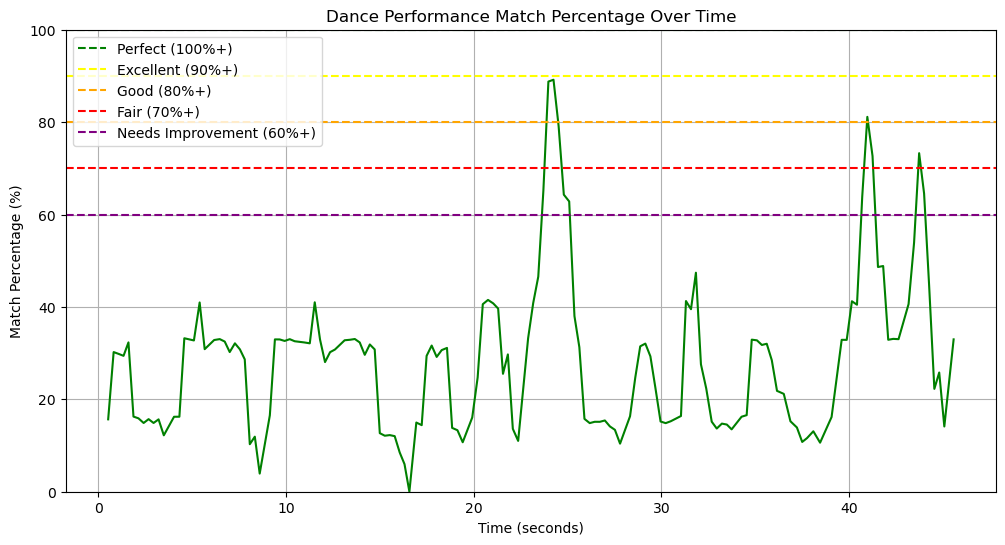

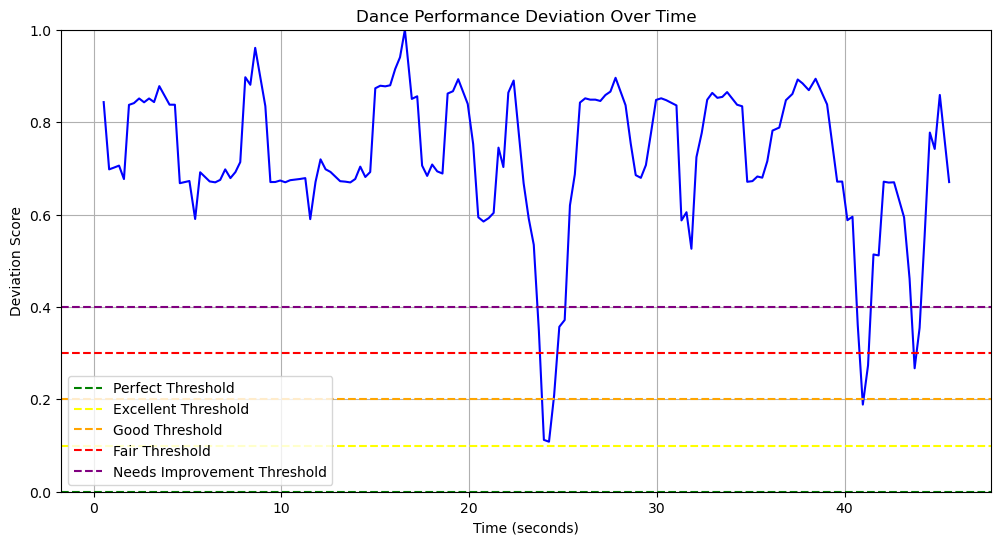

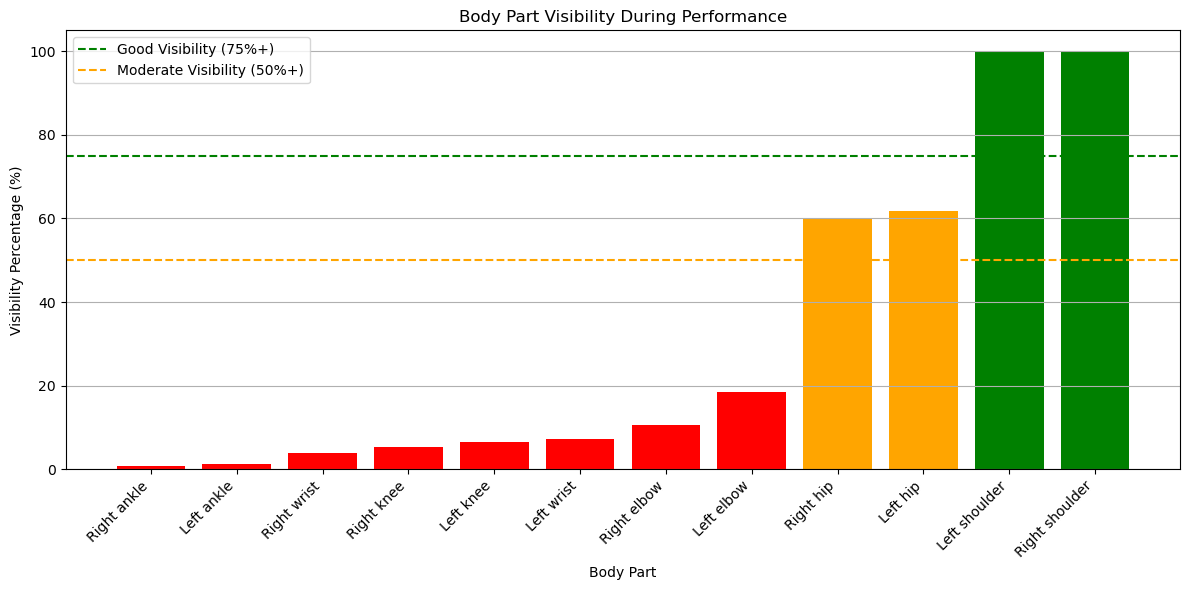

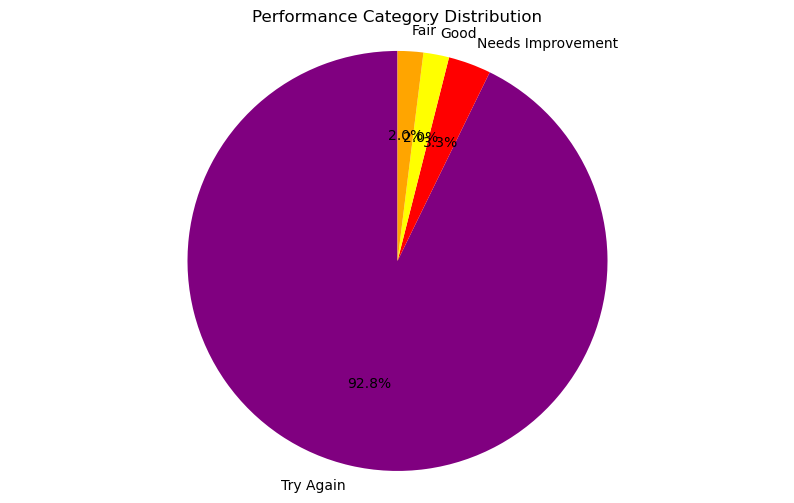

In [14]:
if __name__ == "__main__":
    print("Dance Analysis System")
    print("---------------------")
    print("Loading reference video")
    print("Press 'q' to exit and generate analysis report")
    
    # Run the dance analysis
    run_dance_analysis()

## **Testing on the same video** ##

Our intention is to test our algorithm with the same video by imitating side-by-side display. 

In [15]:
def run_dance_analysis_test_mode():
    video_path = "TimeWarp.mp4"

    ref_cap = cv2.VideoCapture(video_path)
    cam_cap = cv2.VideoCapture(video_path) 

    if not ref_cap.isOpened() or not cam_cap.isOpened():
        print("Error: Cannot open video file")
        return

    ref_fps = ref_cap.get(cv2.CAP_PROP_FPS)
    ref_width = int(ref_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    ref_height = int(ref_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cam_width = int(cam_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    cam_height = int(cam_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    combined_frame_width = ref_width + cam_width
    combined_frame_height = max(ref_height, cam_height)
    cv2.namedWindow('Video and Webcam Playback', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('Video and Webcam Playback', combined_frame_width, combined_frame_height)

    performance_landmarks = []
    performance_timestamps = []
    reference_landmarks = []
    deviation_scores = []
    visibility_data = {}

    process_interval = 2
    frame_count = 0

    ref_frame_time = 1000 / ref_fps
    last_time = time.time() * 1000
    start_time = time.time()

    while ref_cap.isOpened() and cam_cap.isOpened():
        current_time_ms = time.time() * 1000
        time_elapsed = current_time_ms - last_time

        if time_elapsed >= ref_frame_time:
            frames_to_advance = max(1, int(time_elapsed / ref_frame_time))

            for _ in range(frames_to_advance - 1):
                ref_cap.read()
                cam_cap.read()

            ref_success, ref_frame = ref_cap.read()
            cam_success, cam_frame = cam_cap.read()

            if not ref_success or not cam_success or ref_frame is None or cam_frame is None:
                print("End of video reached.")
                break

            last_time = current_time_ms
            if not ref_success:
                print("Reference video ended.")
                break
        else:
            continue  # Skip this loop if it's not time for a new frame

        current_time = time.time() - start_time

        #process frames at intervals to improve speed - REFER TO PROCESS FRAME FUNCTION
        if frame_count % process_interval == 0: #every N
            #process reference frame if we have a new one
            if 'ref_frame' in locals() and ref_frame is not None:
                ref_landmarks, ref_processed = process_frame(ref_frame, holistic)
                prev_ref_processed = ref_processed
                prev_ref_landmarks = ref_landmarks
            else: #take stored previous
                ref_landmarks, ref_processed = prev_ref_landmarks, prev_ref_processed
        
            #process webcam frame
            cam_landmarks, cam_processed = process_frame(cam_frame, holistic)
            prev_cam_processed = cam_processed
            prev_cam_landmarks = cam_landmarks

        if ref_landmarks and cam_landmarks:
            reference_landmarks.append(ref_landmarks)
            performance_landmarks.append(cam_landmarks)
            performance_timestamps.append(current_time)

            deviation, visibility = calculate_deviation(cam_landmarks, ref_landmarks, body_parts)
            deviation_scores.append(deviation)
            match_percentage = (1 - deviation) * 100

            for part, is_visible in visibility.items():
                if part not in visibility_data:
                    visibility_data[part] = []
                visibility_data[part].append(is_visible)

            category = get_deviation_category(deviation, match_categories)

            cv2.putText(cam_processed, f"Match: {match_percentage:.1f}%", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.putText(cam_processed, f"Category: {category}", (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            y_pos = 90
            for part, is_visible in visibility.items():
                if not is_visible:
                    cv2.putText(cam_processed, f"Missing: {part.replace('_',' ')}", (10, y_pos),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
                    y_pos += 20

        if ref_processed is None or cam_processed is None:
            frame_count += 1
            continue

        # Optional: Frame counter for debugging
        cv2.putText(ref_processed, "Reference Video", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        cv2.putText(ref_processed, f"Frame: {frame_count}", (10, 55),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        cv2.putText(cam_processed, "Your Performance", (10, cam_processed.shape[0] - 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(cam_processed, f"Frame: {frame_count}", (10, cam_processed.shape[0] - 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        combined_frame = np.hstack((ref_processed, cam_processed))
        cv2.imshow("Video and Webcam Playback", combined_frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        frame_count += 1

    ref_cap.release()
    cam_cap.release()
    cv2.destroyAllWindows()

    if deviation_scores:
        generate_analysis_report(performance_timestamps, deviation_scores,
                                 visibility_data, match_categories)

Dance Analysis System
---------------------
Loading reference video from: C:\Users\isuni\OneDrive - WHU\WHU MIB\Quarter 4\Text, Image, and Video Mining\material_day2\TimeWarp.mp4
Press 'q' to exit and generate analysis report
End of video reached.

===== Dance Performance Analysis Report =====
OVERALL MATCH: 89.7%
PERFOMANCE CATEGORY: Good

Body Part Visibility:
  left shoulder: 100.0% visible
  right shoulder: 100.0% visible
  left elbow: 98.2% visible
  right elbow: 72.9% visible
  left wrist: 97.5% visible
  right wrist: 76.6% visible
  left hip: 100.0% visible
  right hip: 100.0% visible
  left knee: 93.8% visible
  right knee: 70.5% visible
  left ankle: 95.7% visible
  right ankle: 71.7% visible

Improvement Suggestions:
  Work on keeping these body parts visible to the camera:
    - right elbow
    - right wrist
    - right knee
    - right ankle

Breakdown by Category:
- Excellent: 221 frames (68.0%)
- Fair: 10 frames (3.1%)
- Good: 12 frames (3.7%)
- Needs improvement: 80 fram

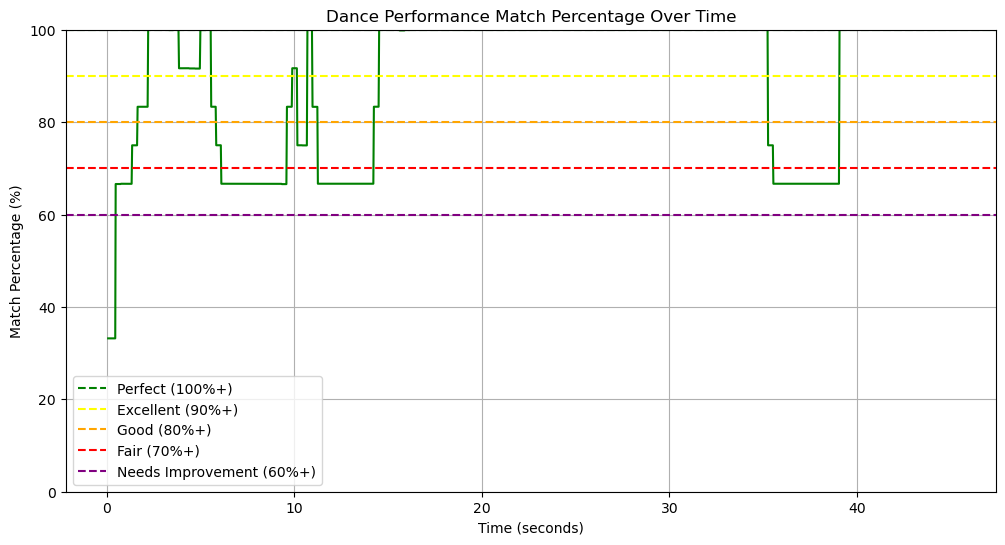

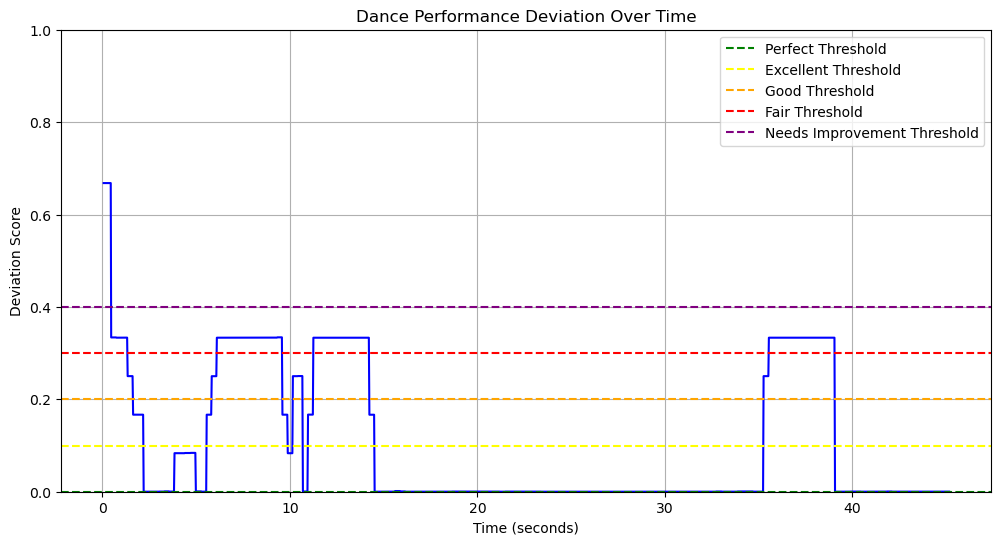

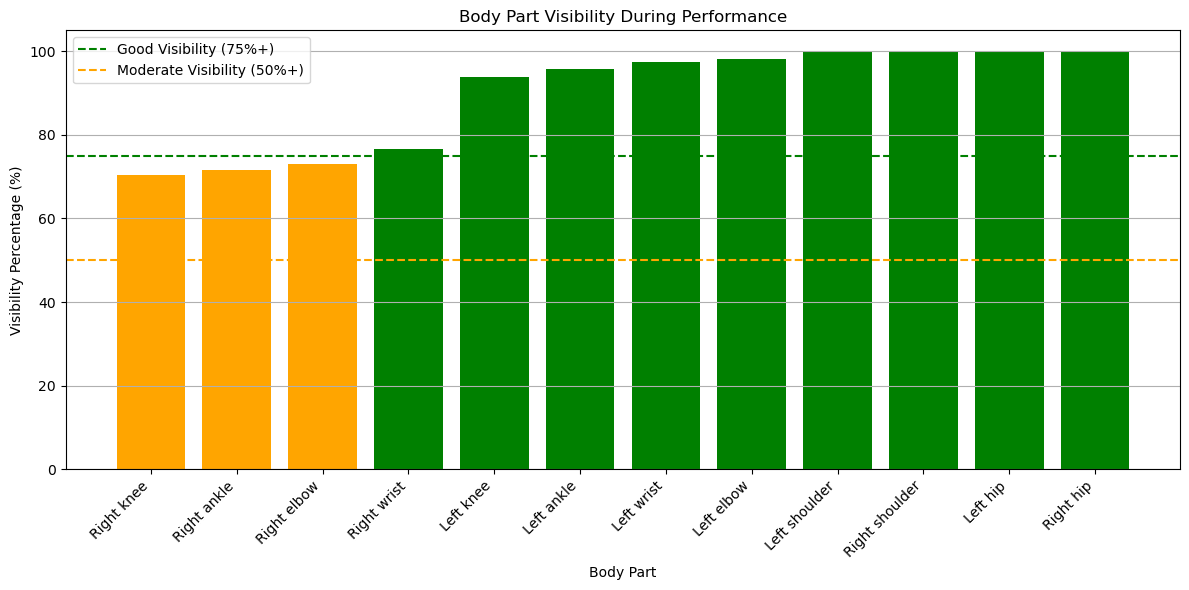

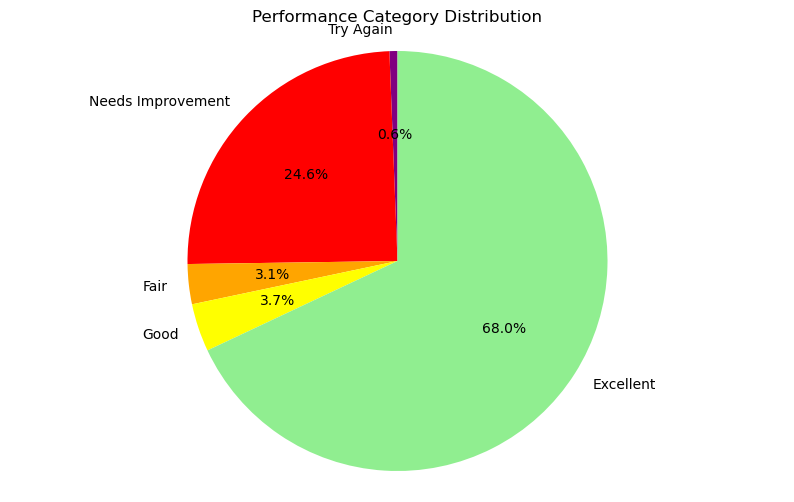

In [16]:
if __name__ == "__main__":
    print("Dance Analysis System")
    print("---------------------")
    print("Loading reference video from: C:\\Users\\isuni\\OneDrive - WHU\\WHU MIB\\Quarter 4\\Text, Image, and Video Mining\\material_day2\\TimeWarp.mp4")
    print("Press 'q' to exit and generate analysis report")
    
    # Run the dance analysis
    run_dance_analysis_test_mode()

Although, the videos are the same we do not have a perfect score. The sources of bias:
- Frame comparison
- Deviation calculation function
- Pose normalization

## **Possible extensions** ##

##### 1. Frame comparison #####

We intentionally speed up video analysis by skipping some frames and sometimes analyze "neighbour" ones. In order to have full coverage, we avoid interval framing. 

##### **Testing with exact comparison (for showcasing purposes)** ##### 

In [17]:
def run_dance_analysis_test_mode_no_cache():
    video_path = "TimeWarp.mp4"

    ref_cap = cv2.VideoCapture(video_path)
    cam_cap = cv2.VideoCapture(video_path)

    if not ref_cap.isOpened() or not cam_cap.isOpened():
        print("Error: Cannot open video file")
        return

    ref_fps = ref_cap.get(cv2.CAP_PROP_FPS)
    ref_width = int(ref_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    ref_height = int(ref_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cam_width = int(cam_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    cam_height = int(cam_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    combined_frame_width = ref_width + cam_width
    combined_frame_height = max(ref_height, cam_height)
    cv2.namedWindow('Video and Webcam Playback', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('Video and Webcam Playback', combined_frame_width, combined_frame_height)

    performance_landmarks = []
    performance_timestamps = []
    reference_landmarks = []
    deviation_scores = []
    visibility_data = {}

    process_interval = 2
    frame_count = 0

    ref_frame_time = 1000 / ref_fps
    last_time = time.time() * 1000
    start_time = time.time()

    while ref_cap.isOpened() and cam_cap.isOpened():
        current_time_ms = time.time() * 1000
        time_elapsed = current_time_ms - last_time

        if time_elapsed >= ref_frame_time:
            frames_to_advance = max(1, int(time_elapsed / ref_frame_time))

            for _ in range(frames_to_advance - 1):
                ref_cap.read()
                cam_cap.read()

            ref_success, ref_frame = ref_cap.read()
            cam_success, cam_frame = cam_cap.read()

            if not ref_success or not cam_success or ref_frame is None or cam_frame is None:
                print("End of video reached.")
                break

            last_time = current_time_ms
            if not ref_success:
                print("Reference video ended.")
                break
        else:
            continue  # Skip this loop if it's not time for a new frame

        current_time = time.time() - start_time
###################################### CHANGE HERE #######################################################
        # No caching: Always process fresh landmarks
        ref_landmarks, ref_processed = process_frame(ref_frame, holistic)
        cam_landmarks, cam_processed = process_frame(cam_frame, holistic)
        
        if ref_landmarks and cam_landmarks:
            reference_landmarks.append(ref_landmarks)
            performance_landmarks.append(cam_landmarks)
            performance_timestamps.append(current_time)
            deviation, visibility = calculate_deviation(cam_landmarks, ref_landmarks, body_parts)
            deviation_scores.append(deviation)
            match_percentage = (1 - deviation) * 100

            for part, is_visible in visibility.items():
                if part not in visibility_data:
                    visibility_data[part] = []
                visibility_data[part].append(is_visible)

            category = get_deviation_category(deviation, match_categories)

            cv2.putText(cam_processed, f"Match: {match_percentage:.1f}%", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.putText(cam_processed, f"Category: {category}", (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            y_pos = 90
            for part, is_visible in visibility.items():
                if not is_visible:
                    cv2.putText(cam_processed, f"Missing: {part.replace('_',' ')}", (10, y_pos),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
                    y_pos += 20

        if ref_processed is None or cam_processed is None:
            frame_count += 1
            continue

        
        cv2.putText(ref_processed, "Reference Video", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        cv2.putText(ref_processed, f"Frame: {frame_count}", (10, 55),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        cv2.putText(cam_processed, "Your Performance", (10, cam_processed.shape[0] - 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(cam_processed, f"Frame: {frame_count}", (10, cam_processed.shape[0] - 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        combined_frame = np.hstack((ref_processed, cam_processed))
        cv2.imshow("Video and Webcam Playback", combined_frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        frame_count += 1

    ref_cap.release()
    cam_cap.release()
    cv2.destroyAllWindows()

    if deviation_scores:
        generate_analysis_report(performance_timestamps, deviation_scores,
                                 visibility_data, match_categories)

Dance Analysis System
---------------------
Loading reference video
Press 'q' to exit and generate analysis report
End of video reached.

===== Dance Performance Analysis Report =====
OVERALL MATCH: 91.2%
PERFOMANCE CATEGORY: Excellent

Body Part Visibility:
  left shoulder: 100.0% visible
  right shoulder: 100.0% visible
  left elbow: 98.8% visible
  right elbow: 73.5% visible
  left wrist: 96.4% visible
  right wrist: 77.1% visible
  left hip: 100.0% visible
  right hip: 100.0% visible
  left knee: 96.4% visible
  right knee: 74.7% visible
  left ankle: 100.0% visible
  right ankle: 77.7% visible

Improvement Suggestions:
  Work on keeping these body parts visible to the camera:
    - right elbow
    - right wrist
    - right knee
    - right ankle

Breakdown by Category:
- Excellent: 122 frames (73.5%)
- Fair: 7 frames (4.2%)
- Good: 2 frames (1.2%)
- Needs improvement: 34 frames (20.5%)
- Try again: 1 frames (0.6%)

Top 3 significant deviations:
- 0m 13.30s (Missing: right_elbow, l

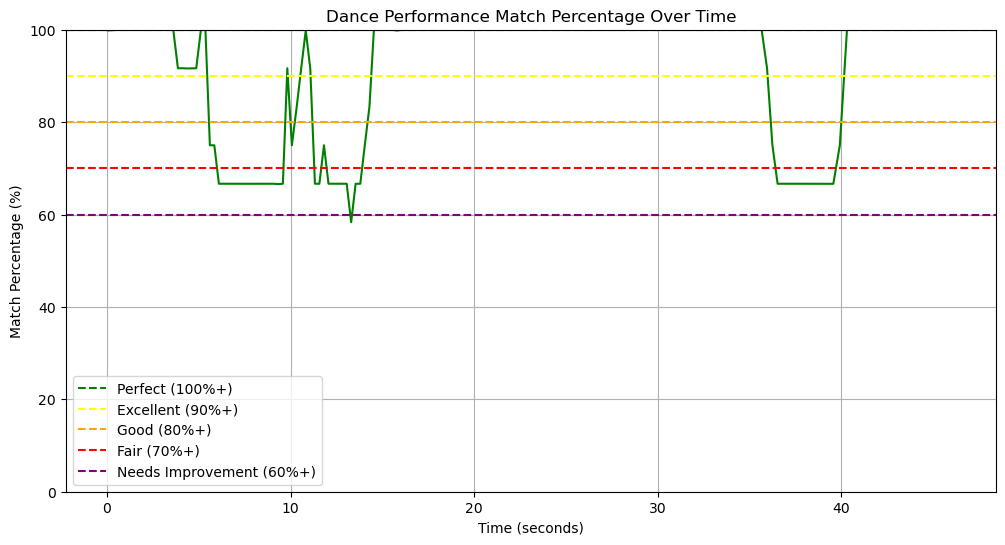

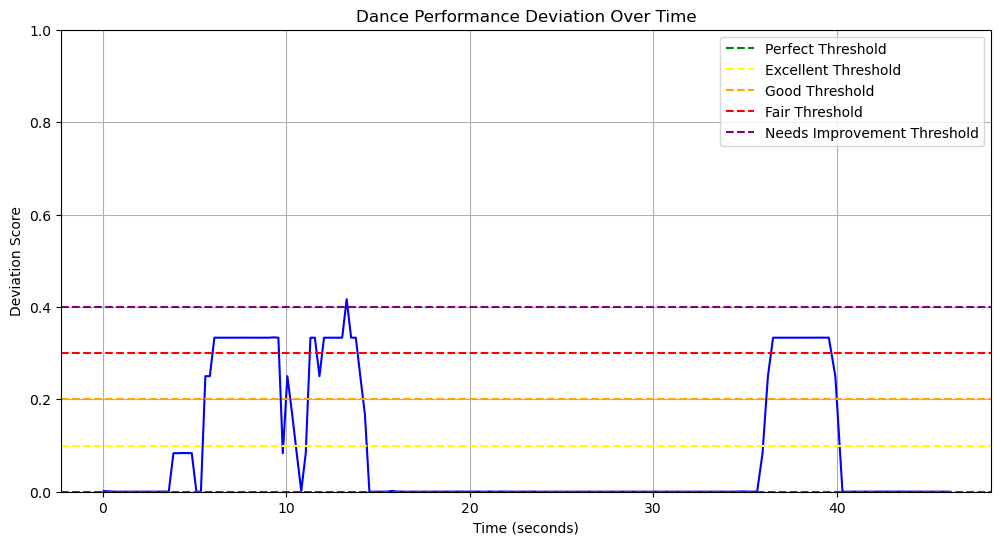

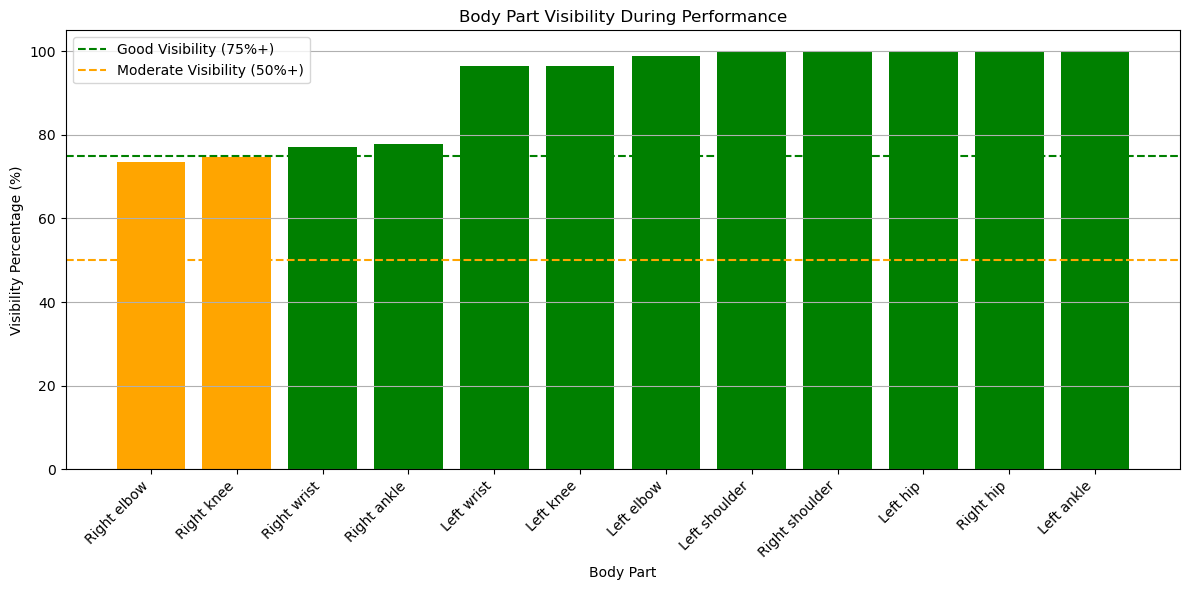

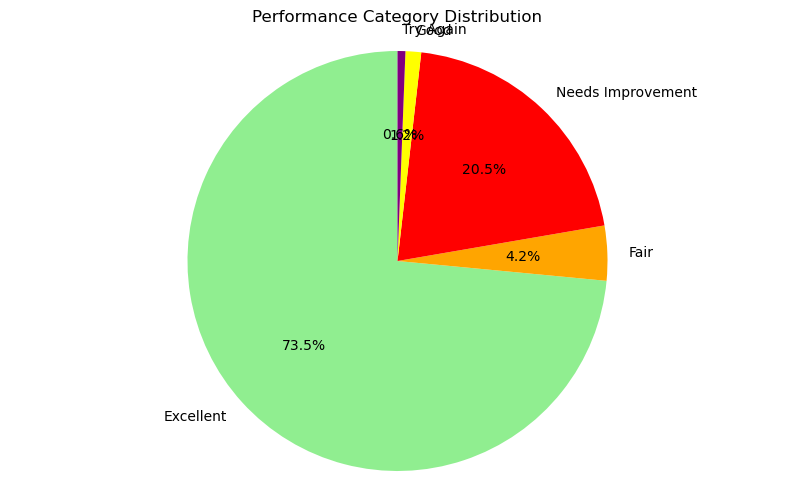

In [18]:
if __name__ == "__main__":
    print("Dance Analysis System")
    print("---------------------")
    print("Loading reference video")
    print("Press 'q' to exit and generate analysis report")
    
    # Run the dance analysis
    run_dance_analysis_test_mode_no_cache()

##### 2. Deviation weighted by visibility #####

Instead of filtering only visible parts (>0.5), we weight deviation from the original video by visibility of body part. If visibility is lower, then error is lower. However this approach leads to another bias since error is mitigated and not penalized as intended. It works fine for comparison with original video but works bad for real examples where missing video body parts are frequent. 

In [19]:
def ext_calculate_deviation(user_landmarks, reference_landmarks, body_parts):
    #mapping from body part names to landmark indices
    landmark_map = {
        "nose": "landmark_0",
        "left_shoulder": "landmark_11", 
        "right_shoulder": "landmark_12",
        "left_elbow": "landmark_13", 
        "right_elbow": "landmark_14",
        "left_wrist": "landmark_15", 
        "right_wrist": "landmark_16",
        "left_hip": "landmark_23", 
        "right_hip": "landmark_24",
        "left_knee": "landmark_25", 
        "right_knee": "landmark_26",
        "left_ankle": "landmark_27", 
        "right_ankle": "landmark_28"
    }

    total_deviation = 0
    count = 0 #count points
    visibility = {} #store info about body part visibility

    for part in body_parts: #iterate through body parts
        if part in landmark_map:
            landmark_id = landmark_map[part]

            #check if landmarks exist and are visible
            user_visible = (landmark_id in user_landmarks and 
                           user_landmarks[landmark_id]["visibility"] > 0.5)
            ref_visible = (landmark_id in reference_landmarks and 
                          reference_landmarks[landmark_id]["visibility"] > 0.5)
            
            visibility[part] = user_visible and ref_visible #store user visibility 

            user_vis = user_landmarks[landmark_id]["visibility"]
            ref_vis = reference_landmarks[landmark_id]["visibility"]
            min_vis = min(user_vis, ref_vis)

            try:
                #calculate Euclidean distance between positions (x,y only)
                user_pos = (user_landmarks[landmark_id]["x"], user_landmarks[landmark_id]["y"])
                ref_pos = (reference_landmarks[landmark_id]["x"], reference_landmarks[landmark_id]["y"])
                squared_dist = ((user_pos[0] - ref_pos[0]) ** 2 + (user_pos[1] - ref_pos[1]) ** 2) #calculate squared distance

                #weight the error by visibility confidence (if visibility is lower, then error is lower)
                weighted_error = squared_dist * min_vis
                total_deviation += weighted_error
                count += 1
            except KeyError:
                continue

    #Cap at 1.0
    avg_deviation = 1.0  
    if count > 0:
        avg_deviation = min(1.0, total_deviation / count) #calculated as SUM OF DEVIATION DISTANCES divided by TOTAL NUMBER OF BODY PARTS

    return avg_deviation, visibility

##### **Testing with weighted error (for showcasing purposes)** ##### 

In [20]:
def run_dance_analysis_test_mode_w_err():
    video_path = "TimeWarp.mp4"

    ref_cap = cv2.VideoCapture(video_path)
    cam_cap = cv2.VideoCapture(video_path)

    if not ref_cap.isOpened() or not cam_cap.isOpened():
        print("Error: Cannot open video file")
        return

    ref_fps = ref_cap.get(cv2.CAP_PROP_FPS)
    ref_width = int(ref_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    ref_height = int(ref_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cam_width = int(cam_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    cam_height = int(cam_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    combined_frame_width = ref_width + cam_width
    combined_frame_height = max(ref_height, cam_height)
    cv2.namedWindow('Video and Webcam Playback', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('Video and Webcam Playback', combined_frame_width, combined_frame_height)

    performance_landmarks = []
    performance_timestamps = []
    reference_landmarks = []
    deviation_scores = []
    visibility_data = {}

    process_interval = 2
    frame_count = 0

    ref_frame_time = 1000 / ref_fps
    last_time = time.time() * 1000
    start_time = time.time()

    while ref_cap.isOpened() and cam_cap.isOpened():
        current_time_ms = time.time() * 1000
        time_elapsed = current_time_ms - last_time

        if time_elapsed >= ref_frame_time:
            frames_to_advance = max(1, int(time_elapsed / ref_frame_time))

            for _ in range(frames_to_advance - 1):
                ref_cap.read()
                cam_cap.read()

            ref_success, ref_frame = ref_cap.read()
            cam_success, cam_frame = cam_cap.read()

            if not ref_success or not cam_success or ref_frame is None or cam_frame is None:
                print("End of video reached.")
                break

            last_time = current_time_ms
            if not ref_success:
                print("Reference video ended.")
                break
        else:
            continue  # Skip this loop if it's not time for a new frame

        current_time = time.time() - start_time

        # 🚫 No caching: Always process fresh landmarks
        ref_landmarks, ref_processed = process_frame(ref_frame, holistic)
        ########
        #center, scale = get_normalization_params(ref_landmarks)
        #ref_landmarks = apply_normalization(ref_landmarks, center, scale)

        cam_landmarks, cam_processed = process_frame(cam_frame, holistic)
        #cam_landmarks = apply_normalization(cam_landmarks, center, scale)
        ########
        if ref_landmarks and cam_landmarks:
            reference_landmarks.append(ref_landmarks)
            performance_landmarks.append(cam_landmarks)
            performance_timestamps.append(current_time)
###################################### CHANGE HERE #######################################################
            deviation, visibility = ext_calculate_deviation(cam_landmarks, ref_landmarks, body_parts)
            deviation_scores.append(deviation)
            match_percentage = (1 - deviation) * 100

            for part, is_visible in visibility.items():
                if part not in visibility_data:
                    visibility_data[part] = []
                visibility_data[part].append(is_visible)

            category = get_deviation_category(deviation, match_categories)

            cv2.putText(cam_processed, f"Match: {match_percentage:.1f}%", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.putText(cam_processed, f"Category: {category}", (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            y_pos = 90
            for part, is_visible in visibility.items():
                if not is_visible:
                    cv2.putText(cam_processed, f"Missing: {part.replace('_',' ')}", (10, y_pos),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
                    y_pos += 20

        if ref_processed is None or cam_processed is None:
            frame_count += 1
            continue

        
        cv2.putText(ref_processed, "Reference Video", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        cv2.putText(ref_processed, f"Frame: {frame_count}", (10, 55),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        cv2.putText(cam_processed, "Your Performance", (10, cam_processed.shape[0] - 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(cam_processed, f"Frame: {frame_count}", (10, cam_processed.shape[0] - 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        combined_frame = np.hstack((ref_processed, cam_processed))
        cv2.imshow("Video and Webcam Playback", combined_frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        frame_count += 1

    ref_cap.release()
    cam_cap.release()
    cv2.destroyAllWindows()

    if deviation_scores:
        generate_analysis_report(performance_timestamps, deviation_scores,
                                 visibility_data, match_categories)

Dance Analysis System
---------------------
Loading reference video
Press 'q' to exit and generate analysis report
End of video reached.

===== Dance Performance Analysis Report =====
OVERALL MATCH: 100.0%
PERFOMANCE CATEGORY: Excellent

Body Part Visibility:
  left shoulder: 100.0% visible
  right shoulder: 100.0% visible
  left elbow: 100.0% visible
  right elbow: 75.3% visible
  left wrist: 99.4% visible
  right wrist: 77.1% visible
  left hip: 100.0% visible
  right hip: 100.0% visible
  left knee: 99.4% visible
  right knee: 75.3% visible
  left ankle: 98.2% visible
  right ankle: 78.3% visible

Improvement Suggestions:
  Work on keeping these body parts visible to the camera:
    - right elbow
    - right wrist
    - right knee
    - right ankle

Breakdown by Category:
- Excellent: 166 frames (100.0%)

Analysis complete! Results saved to 'dance_analysis_results' folder.
The following files were generated:
1. match_percentage_over_time.png - Graph showing match percentage over tim

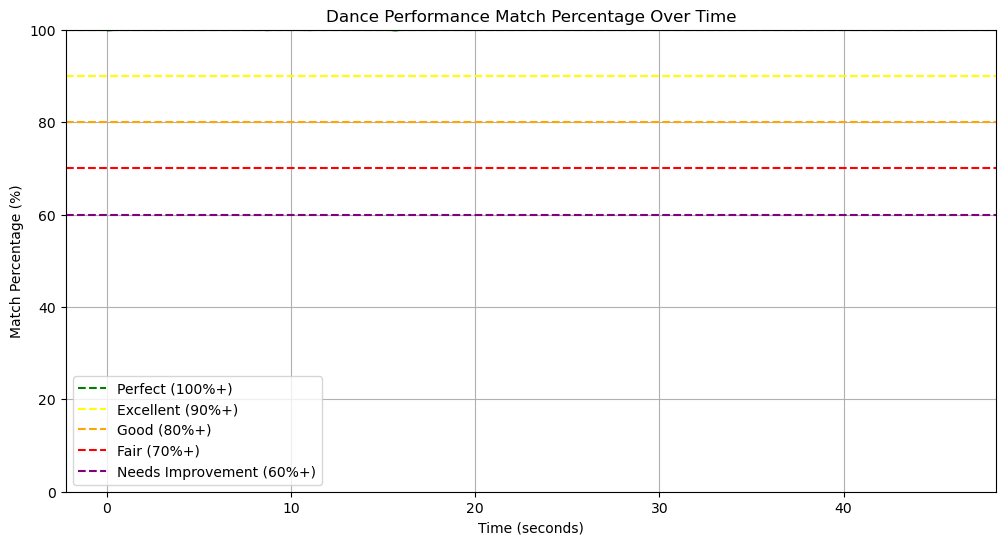

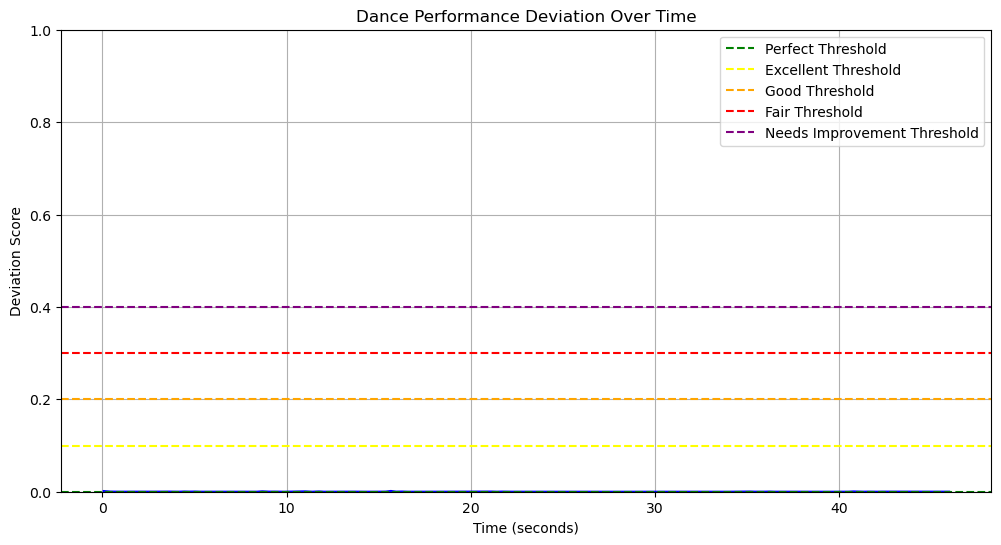

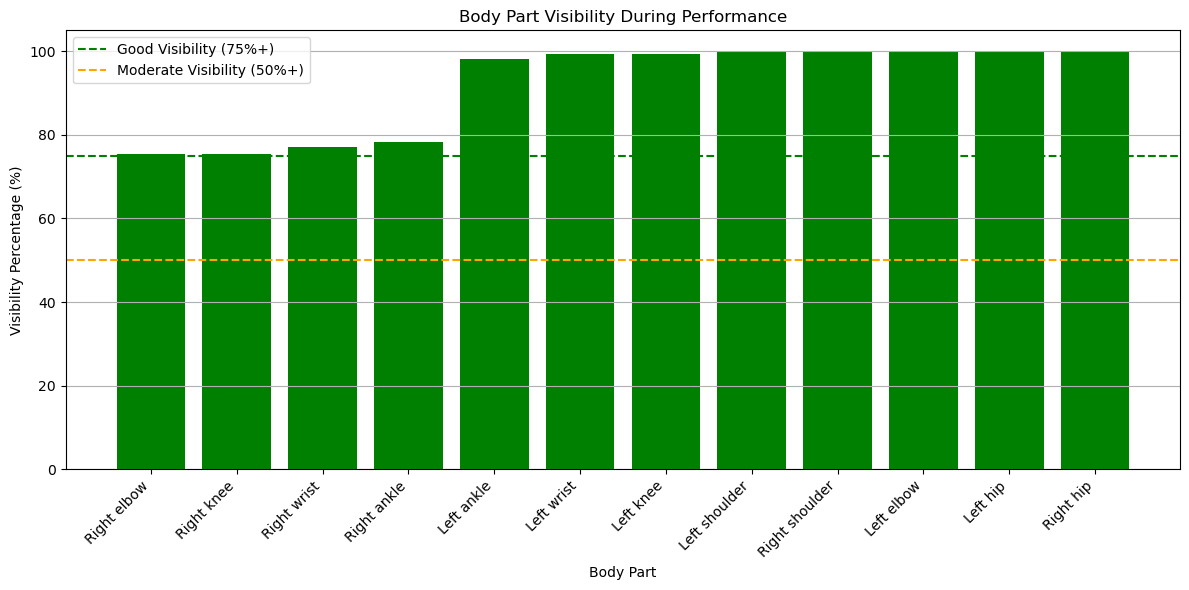

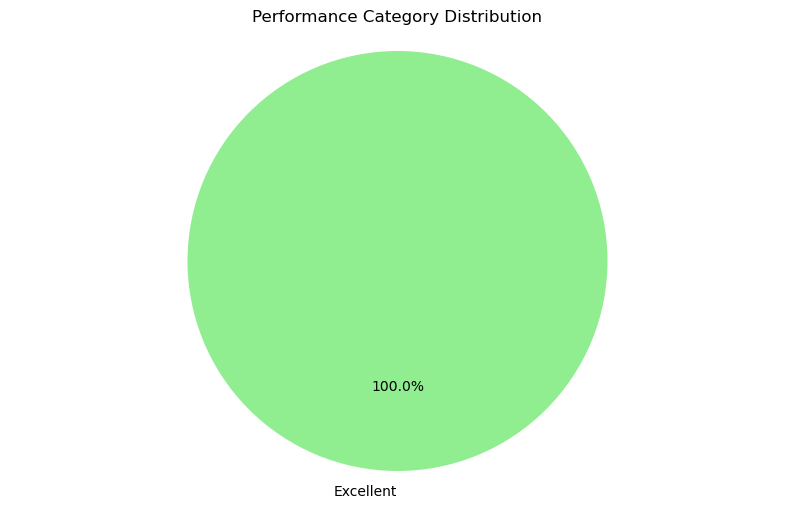

In [21]:
if __name__ == "__main__":
    print("Dance Analysis System")
    print("---------------------")
    print("Loading reference video")
    print("Press 'q' to exit and generate analysis report")
    
    # Run the dance analysis
    run_dance_analysis_test_mode_w_err()

##### 3. Pose normalization #####

Raw MediaPipe landmark coordinates (x, y) are relative to the image frame, but still affected by distance from camera, person's height/body size, slight camera angle differences. By centering and scaling each pose, we bring all poses into a standard coordinate space.
- Centering: subtract the midpoint between hips from all landmarks.
- Scale: divide by a body-based distance (like shoulder width).

In [22]:
def get_normalization_params(landmarks_dict):
    required = ["landmark_11", "landmark_12", "landmark_23", "landmark_24"] #shoulders & hips
    for key in required:
        if key not in landmarks_dict or landmarks_dict[key]["visibility"] < 0.5:
            print(f"Warning: Cannot compute normalization params — missing {key}")
            return None, None

    #center at hip midpoint
    center_x = (landmarks_dict["landmark_23"]["x"] + landmarks_dict["landmark_24"]["x"]) / 2
    center_y = (landmarks_dict["landmark_23"]["y"] + landmarks_dict["landmark_24"]["y"]) / 2

    #scale from shoulder distance
    dx = landmarks_dict["landmark_11"]["x"] - landmarks_dict["landmark_12"]["x"]
    dy = landmarks_dict["landmark_11"]["y"] - landmarks_dict["landmark_12"]["y"]
    scale = (dx**2 + dy**2) ** 0.5

    if scale < 1e-5:
        print("Warning: Scale too small for normalization")
        return None, None

    return (center_x, center_y), scale

def apply_normalization(landmarks_dict, center, scale):
    if center is None or scale is None or landmarks_dict is None:
        return None

    center_x, center_y = center
    normalized = {}

    for key, lm in landmarks_dict.items():
        normalized[key] = {
            "x": (lm["x"] - center_x) / scale,
            "y": (lm["y"] - center_y) / scale,
            "z": lm["z"] / scale,
            "visibility": lm["visibility"]
        }

    return normalized

##### **Testing with normalization (for showcasing purposes)** #####

We intentionally introduce bias by generalizing (e.g. scaling by namely shoulders and hips). Due to this fact, when comparing both original videos pose normalization would lead to lower accuracy. However in real-case scenarious it would help to get more reliable results. 

In [23]:
def run_dance_analysis_test_mode_norm():
    video_path = "TimeWarp.mp4"

    ref_cap = cv2.VideoCapture(video_path)
    cam_cap = cv2.VideoCapture(video_path)

    if not ref_cap.isOpened() or not cam_cap.isOpened():
        print("Error: Cannot open video file")
        return

    ref_fps = ref_cap.get(cv2.CAP_PROP_FPS)
    ref_width = int(ref_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    ref_height = int(ref_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cam_width = int(cam_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    cam_height = int(cam_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    combined_frame_width = ref_width + cam_width
    combined_frame_height = max(ref_height, cam_height)
    cv2.namedWindow('Video and Webcam Playback', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('Video and Webcam Playback', combined_frame_width, combined_frame_height)

    performance_landmarks = []
    performance_timestamps = []
    reference_landmarks = []
    deviation_scores = []
    visibility_data = {}

    process_interval = 2
    frame_count = 0

    ref_frame_time = 1000 / ref_fps
    last_time = time.time() * 1000
    start_time = time.time()

    while ref_cap.isOpened() and cam_cap.isOpened():
        current_time_ms = time.time() * 1000
        time_elapsed = current_time_ms - last_time

        if time_elapsed >= ref_frame_time:
            frames_to_advance = max(1, int(time_elapsed / ref_frame_time))

            for _ in range(frames_to_advance - 1):
                ref_cap.read()
                cam_cap.read()

            ref_success, ref_frame = ref_cap.read()
            cam_success, cam_frame = cam_cap.read()

            if not ref_success or not cam_success or ref_frame is None or cam_frame is None:
                print("End of video reached.")
                break

            last_time = current_time_ms
            if not ref_success:
                print("Reference video ended.")
                break
        else:
            continue  # Skip this loop if it's not time for a new frame

        current_time = time.time() - start_time

        # 🚫 No caching: Always process fresh landmarks
        ref_landmarks, ref_processed = process_frame(ref_frame, holistic)
 ######################### CHANGE HERE ######################################
        center, scale = get_normalization_params(ref_landmarks)
        ref_landmarks = apply_normalization(ref_landmarks, center, scale)

        cam_landmarks, cam_processed = process_frame(cam_frame, holistic)
        cam_landmarks = apply_normalization(cam_landmarks, center, scale)
        ########
        if ref_landmarks and cam_landmarks:
            reference_landmarks.append(ref_landmarks)
            performance_landmarks.append(cam_landmarks)
            performance_timestamps.append(current_time)

            deviation, visibility = calculate_deviation(cam_landmarks, ref_landmarks, body_parts)
            deviation_scores.append(deviation)
            match_percentage = (1 - deviation) * 100

            for part, is_visible in visibility.items():
                if part not in visibility_data:
                    visibility_data[part] = []
                visibility_data[part].append(is_visible)

            category = get_deviation_category(deviation, match_categories)

            cv2.putText(cam_processed, f"Match: {match_percentage:.1f}%", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            cv2.putText(cam_processed, f"Category: {category}", (10, 60),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

            y_pos = 90
            for part, is_visible in visibility.items():
                if not is_visible:
                    cv2.putText(cam_processed, f"Missing: {part.replace('_',' ')}", (10, y_pos),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
                    y_pos += 20

        if ref_processed is None or cam_processed is None:
            frame_count += 1
            continue

        
        cv2.putText(ref_processed, "Reference Video", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        cv2.putText(ref_processed, f"Frame: {frame_count}", (10, 55),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
        cv2.putText(cam_processed, "Your Performance", (10, cam_processed.shape[0] - 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(cam_processed, f"Frame: {frame_count}", (10, cam_processed.shape[0] - 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        combined_frame = np.hstack((ref_processed, cam_processed))
        cv2.imshow("Video and Webcam Playback", combined_frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        frame_count += 1

    ref_cap.release()
    cam_cap.release()
    cv2.destroyAllWindows()

    if deviation_scores:
        generate_analysis_report(performance_timestamps, deviation_scores,
                                 visibility_data, match_categories)

Dance Analysis System
---------------------
Loading reference video
Press 'q' to exit and generate analysis report
End of video reached.

===== Dance Performance Analysis Report =====
OVERALL MATCH: 84.4%
PERFOMANCE CATEGORY: Good

Body Part Visibility:
  left shoulder: 100.0% visible
  right shoulder: 100.0% visible
  left elbow: 100.0% visible
  right elbow: 75.6% visible
  left wrist: 98.2% visible
  right wrist: 79.8% visible
  left hip: 100.0% visible
  right hip: 100.0% visible
  left knee: 99.4% visible
  right knee: 73.8% visible
  left ankle: 100.0% visible
  right ankle: 76.2% visible

Improvement Suggestions:
  Work on keeping these body parts visible to the camera:
    - right elbow
    - right wrist
    - right knee
    - right ankle

Breakdown by Category:
- Excellent: 119 frames (70.8%)
- Fair: 3 frames (1.8%)
- Good: 6 frames (3.6%)
- Needs improvement: 16 frames (9.5%)
- Try again: 24 frames (14.3%)

Top 3 significant deviations:
- 0m 3.37s (Missing: None)
- 0m 6.61s (

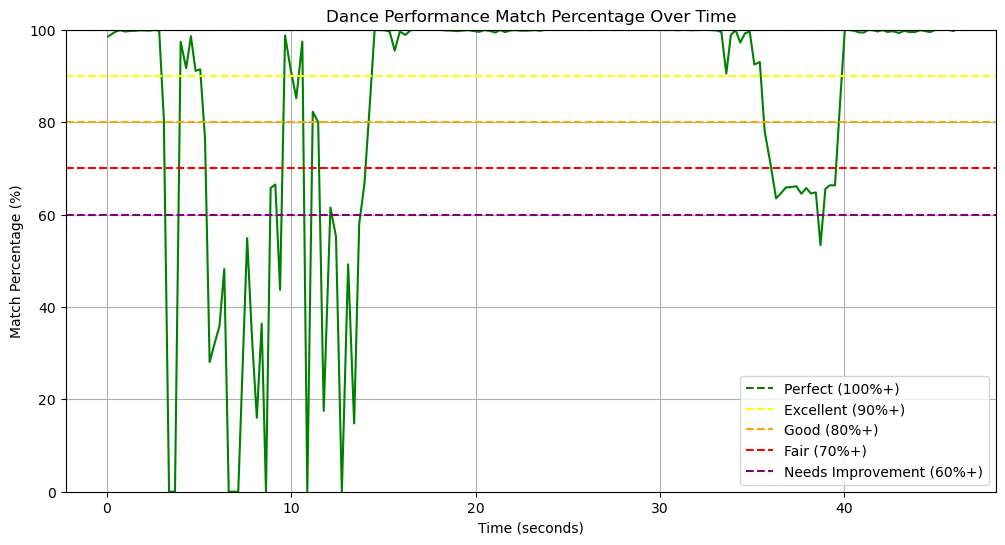

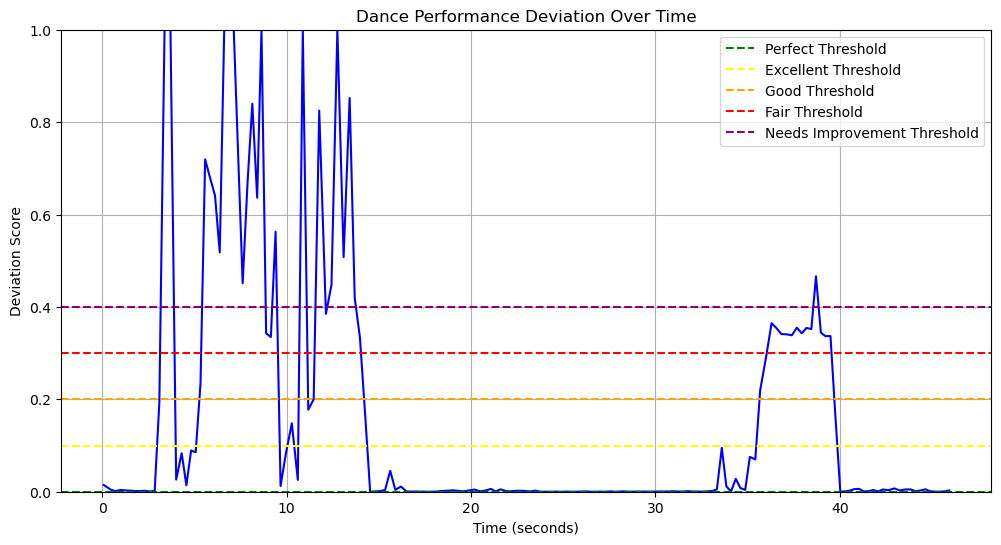

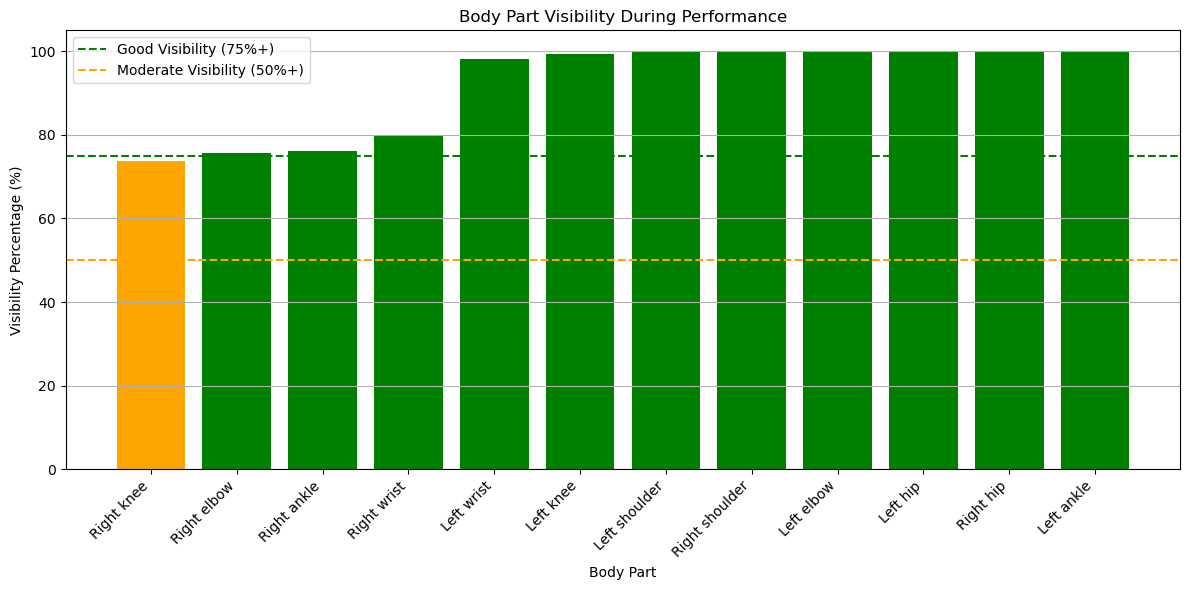

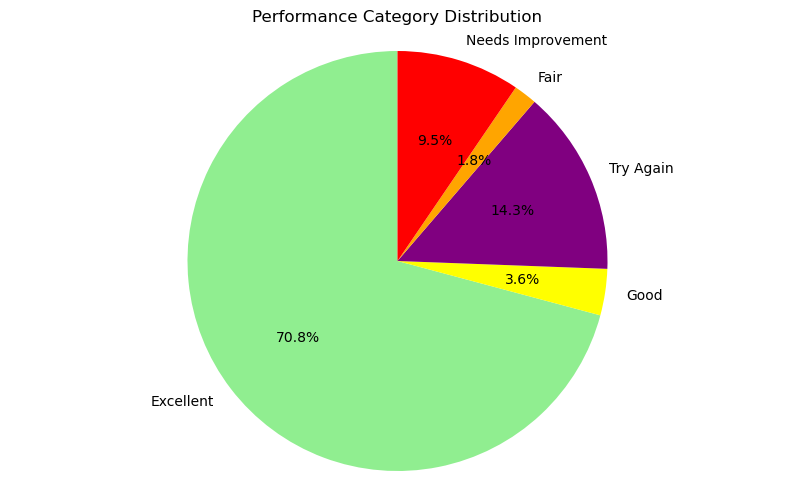

In [24]:
if __name__ == "__main__":
    print("Dance Analysis System")
    print("---------------------")
    print("Loading reference video")
    print("Press 'q' to exit and generate analysis report")
    
    # Run the dance analysis
    run_dance_analysis_test_mode_norm()